# Segmentation of Neighborhood, Jakarta.

The goal of this notebook is to provide data driven venue in Jakarta, Indonesia. The report should give an insight for traveler to understand the location on restaurant or any other activity in the area. Notebook contain several parts :
- Data Acquisition
- Cleanup
- Processing and visualization
- Segmentation and Clustering
- Conclusion

In [1]:
# Import Libraries
import pandas as pd
import os,sys
import urllib
import requests 
import io
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from geopy.geocoders import Nominatim
from IPython.display import HTML
import base64
import seaborn as sns

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


In [2]:
def csv_to_df(urli):
    dataresult=pd.read_csv(io.StringIO(requests.get(urli).content.decode('utf-8')), error_bad_lines=False)
    return dataresult

In [3]:
jakarta_df_raw = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/tbl_kodepos.csv")

In [4]:
print(jakarta_df_raw.shape)
jakarta_df_raw.head()

(81248, 6)


,id,kelurahan,kecamatan,kabupaten,provinsi,kodepos
0,1,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110
1,2,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120
2,3,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130
3,4,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140
4,5,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150


In [5]:
#filter dataset with Jakarta province only
jakarta_df1=jakarta_df_raw.loc[jakarta_df_raw['provinsi'] == 'DKI JAKARTA']

In [6]:
print(jakarta_df1.shape)
jakarta_df1.head()

(267, 6)


,id,kelurahan,kecamatan,kabupaten,provinsi,kodepos
0,1,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110
1,2,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120
2,3,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130
3,4,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140
4,5,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150


In [7]:
#Rename Columns to English
jakarta_df1.rename(columns={'provinsi': 'Province'}, inplace=True)
jakarta_df1.rename(columns={'kabupaten': 'Regency'}, inplace=True)
jakarta_df1.rename(columns={'kecamatan': 'District'}, inplace=True)
jakarta_df1.rename(columns={'kelurahan': 'Subdistricts'}, inplace=True)
jakarta_df1.rename(columns={'kodepos': 'PostalCode'}, inplace=True)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [8]:
print(jakarta_df1.shape)
jakarta_df1.head()

(267, 6)


,id,Subdistricts,District,Regency,Province,PostalCode
0,1,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110
1,2,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120
2,3,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130
3,4,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140
4,5,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150


In [9]:
# Save file to CSV function.
def file_to_save( dataframe, fname = "CSV Files Available", csvfile = "dataframe.csv"):  
    csv = dataframe.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    filelink = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    htmlfile = filelink.format(payload=payload,title=fname,filename=csvfile)
    return HTML(htmlfile)

In [10]:
# Save Jakarta dataframe for future use
file = "Jakarta_postal_code.csv"
link = "Storage:Jakarta_postal_code.csv"
file_to_save(jakarta_df1,file,link)


In [11]:
# Filter needed columns only
jakarta_df2=jakarta_df1.filter(['Subdistricts','District','Regency', 'Province','PostalCode'], axis=1)

In [12]:
print(jakarta_df2.shape)
jakarta_df2.head()

(267, 5)


,Subdistricts,District,Regency,Province,PostalCode
0,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110
1,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120
2,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130
3,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140
4,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150


In [13]:
# Get Coordinate for each zip code using geolocator API coordinate
import time
geolocator = Nominatim()
jakarta_df3=jakarta_df2
idx=-1
for kelurahan, kecamatan, kabupaten, zipcode in zip(jakarta_df2['Subdistricts'],jakarta_df2['District'], \
                                                    jakarta_df2['Regency'], jakarta_df2['PostalCode'] ):
    idx= idx+1
    #alamat = kelurahan + ", " + "Jakarta, Indonesia"
    alamat = str(zipcode) + " " + "Jakarta, Indonesia"
    try :
        location = geolocator.geocode(alamat)
        rowIndex = jakarta_df3.index[idx]
        print(rowIndex)
        print(alamat)
        print("====>", location)
        print("====>",(location.latitude, location.longitude))
        jakarta_df3.loc[rowIndex, 'Latitude'] = location.latitude
        jakarta_df3.loc[rowIndex, 'Longitude'] = location.longitude
        jakarta_df3.loc[rowIndex, 'Note'] = alamat
        time.sleep(1) # Delay every seconds 
    except:
        continue  


0
10110 Jakarta, Indonesia
====> RW 02, JKT, 10110, Indonesia
====> (-6.17581116679651, 106.826905664396)
1
10120 Jakarta, Indonesia
====> RW 02, JKT, 10120, Indonesia
====> (-6.16206477977513, 106.826741383746)
2
10130 Jakarta, Indonesia
====> RW 08, JKT, 10130, Indonesia
====> (-6.16488195810053, 106.818566007249)
3
10140 Jakarta, Indonesia
====> RW 01, JKT, 10140, Indonesia
====> (-6.1651961, 106.8102152)
4
10150 Jakarta, Indonesia
====> RW 05, JKT, 10150, Indonesia
====> (-6.16740539340644, 106.812690493727)
5
10160 Jakarta, Indonesia
====> RW 03, JKT, 10160, Indonesia
====> (-6.17571843553567, 106.817905617335)
6
10210 Jakarta, Indonesia
====> RW 03, Bendungan Hilir, Tanah Abang, JKT, 10210, Indonesia
====> (-6.2116445, 106.8116372)
7
10220 Jakarta, Indonesia
====> RT 13, JKT, 10220, Indonesia
====> (-6.20911508786607, 106.818156747136)
8
10230 Jakarta, Indonesia
====> RW 12, JKT, 10230, Indonesia
====> (-6.19285524074269, 106.812846050231)
9
10240 Jakarta, Indonesia
====> RW 03, 

72
11470 Jakarta, Indonesia
====> RW 06, Tanjung Duren Selatan, Grogol Petamburan, Jakarta Barat, JKT, 11470, Indonesia
====> (-6.1781941, 106.7913684)
73
11470 Jakarta, Indonesia
====> RW 06, Tanjung Duren Selatan, Grogol Petamburan, Jakarta Barat, JKT, 11470, Indonesia
====> (-6.1781941, 106.7913684)
74
11480 Jakarta, Indonesia
====> RW 01, Jakarta Barat, JKT, 11480, Indonesia
====> (-6.19654386364847, 106.789909767614)
75
11480 Jakarta, Indonesia
====> RW 01, Jakarta Barat, JKT, 11480, Indonesia
====> (-6.19654386364847, 106.789909767614)
76
11510 Jakarta, Indonesia
====> RW 12, Jakarta Barat, JKT, 11510, Indonesia
====> (-6.17770919107008, 106.772140089201)
77
11520 Jakarta, Indonesia
====> RT 03, Jakarta Barat, JKT, 11520, Indonesia
====> (-6.16733250326393, 106.759856521167)
78
11520 Jakarta, Indonesia
====> RT 03, Jakarta Barat, JKT, 11520, Indonesia
====> (-6.16733250326393, 106.759856521167)
79
11530 Jakarta, Indonesia
====> RW 13, Kebon Jeruk, Jakarta Barat, JKT, 11530, Indon

138
12640 Jakarta, Indonesia
====> RW 02, Jakarta Selatan, JKT, 12640, Indonesia
====> (-6.345044, 106.8337234)
139
12710 Jakarta, Indonesia
====> RW 02, Jakarta Selatan, JKT, 12710, Indonesia
====> (-6.24446746449829, 106.818480951476)
140
12720 Jakarta, Indonesia
====> RW 03, Pela Mampang, Mampang Prapatan, Jakarta Selatan, JKT, 12720, Indonesia
====> (-6.2476943, 106.8157651)
141
12730 Jakarta, Indonesia
====> RW 01, Jakarta Selatan, JKT, 12730, Indonesia
====> (-6.25662771227518, 106.81541322577)
142
12740 Jakarta, Indonesia
====> RW 06, Jakarta Selatan, JKT, 12740, Indonesia
====> (-6.26292724962217, 106.840490114179)
144
12760 Jakarta, Indonesia
====> RW 01, Jakarta Selatan, JKT, 12760, Indonesia
====> (-6.25531754656587, 106.83404065322)
145
12770 Jakarta, Indonesia
====> RT 03, Jakarta Selatan, JKT, 12770, Indonesia
====> (-6.24769512654386, 106.851381161787)
146
12770 Jakarta, Indonesia
====> RT 03, Jakarta Selatan, JKT, 12770, Indonesia
====> (-6.24769512654386, 106.851381161

205
13710 Jakarta, Indonesia
====> Jakarta, Jimbaran, Kuta Selatan, Bali, 0361, Indonesia
====> (-8.7996802, 115.1506101)
206
13720 Jakarta, Indonesia
====> RW 07, Jakarta Timur, JKT, 13720, Indonesia
====> (-6.36236125988868, 106.890956667284)
207
13730 Jakarta, Indonesia
====> Jakarta, Jimbaran, Kuta Selatan, Bali, 0361, Indonesia
====> (-8.7996802, 115.1506101)
208
13740 Jakarta, Indonesia
====> RW 03, Jakarta Timur, JKT, 13740, Indonesia
====> (-6.32642543743258, 106.879494794934)
209
13750 Jakarta, Indonesia
====> Jakarta, Jimbaran, Kuta Selatan, Bali, 0361, Indonesia
====> (-8.7996802, 115.1506101)
210
13760 Jakarta, Indonesia
====> RW 12, Jakarta Timur, JKT, 13760, Indonesia
====> (-6.29903120979939, 106.85953015983)
211
13770 Jakarta, Indonesia
====> RW 06, Jakarta Timur, JKT, 13770, Indonesia
====> (-6.31307600768223, 106.860689277655)
212
13780 Jakarta, Indonesia
====> Jakarta, Jimbaran, Kuta Selatan, Bali, 0361, Indonesia
====> (-8.7996802, 115.1506101)
213
13790 Jakarta, In

In [16]:
print(jakarta_df3.shape)
jakarta_df3.head()

(267, 8)


,Subdistricts,District,Regency,Province,PostalCode,Latitude,Longitude,Note
0,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110,-6.175811,106.826906,"10110 Jakarta, Indonesia"
1,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120,-6.162065,106.826741,"10120 Jakarta, Indonesia"
2,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130,-6.164882,106.818566,"10130 Jakarta, Indonesia"
3,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140,-6.165196,106.810215,"10140 Jakarta, Indonesia"
4,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150,-6.167405,106.812690,"10150 Jakarta, Indonesia"


In [17]:
jakarta_df4=jakarta_df3.filter(['Subdistricts','District','Regency', 'Province','PostalCode','Latitude','Longitude'], axis=1)

In [18]:
print(jakarta_df4.shape)
jakarta_df4.head()

(267, 7)


,Subdistricts,District,Regency,Province,PostalCode,Latitude,Longitude
0,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110,-6.175811,106.826906
1,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120,-6.162065,106.826741
2,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130,-6.164882,106.818566
3,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140,-6.165196,106.810215
4,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150,-6.167405,106.812690


In [19]:
# Save Jakarta dataframe for future use
file = "Jakarta_postal_code_with_coordinate.csv"
link = "Storage:Jakarta_postal_code_with_coordinate.csv"
file_to_save(jakarta_df4,file,link)

#### Find Null value in dataframe

Dataframe check for any null value. Do neccessary step to clean up.

In [20]:
jakarta_df4.isnull().sum()

Subdistricts    0
District        0
Regency         0
Province        0
PostalCode      0
Latitude        1
Longitude       1
dtype: int64

Cleaned null from dataframe

In [21]:
jakarta_df5=jakarta_df4
jakarta_df5.dropna(subset=['Latitude'], how='any', inplace = True)

In [22]:
print(jakarta_df5.shape)
jakarta_df5.head()

# Save Jakarta dataframe for future use
file = "Jakarta_postal_code_with_coordinate_cleaned.csv"
link = "Storage:Jakarta_postal_code_with_coordinate_cleaned.csv"
file_to_save(jakarta_df5,file,link)


(266, 7)


#### Visualized Dataframe in map

In [23]:
# Get jakarta coordinate
location = geolocator.geocode("Jakarta Indonesia")
latitude=location.latitude
longitude=location.longitude
print("====>", location)
print("====>",(location.latitude, location.longitude))


====> JKT, Indonesia
====> (-6.1753942, 106.827183)


In [24]:
# create map of Jakarta using latitude and longitude values above
jakarta_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, postalcode in zip(jakarta_df5['Latitude'], jakarta_df5['Longitude'],  jakarta_df5['Subdistricts'], jakarta_df5['PostalCode']):
    label = '{},{}'.format(neighborhood,postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(jakarta_map)
jakarta_map

In [66]:
# This is Froursquare Credential
# The code was removed by Watson Studio for sharing.
CLIENT_ID = 'hidden'
CLIENT_SECRET = 'hidden'
VERSION = '20180605' # Foursquare API version
LIMIT = 500
radius=500

In [67]:
# Get list of venue on 500 meter radius, limit by limit value
# Get venue function.
def getVenueList(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format( \
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # insert result into dataframe
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['id'],
            v['venue']['categories'][0]['name']) for v in results])

    neigh_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    neigh_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'VenueID',     
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue CatID', 
                  'Venue Category']
    
    return(neigh_venues)


In [27]:
# Get Jakarta Venue using API
jakarta_venuelist= getVenueList(names=jakarta_df5['Subdistricts'],
                                   latitudes=jakarta_df5['Latitude'],
                                   longitudes=jakarta_df5['Longitude']
                                  )


GAMBIR
KEBON KELAPA
PETOJO UTARA
DURI PULO
CIDENG
PETOJO SELATAN
BENDUNGAN HILIR
KARET TENGSIN
KEBON MELATI
KEBON KACANG
KAMPUNG BALI
PETAMBURAN
GELORA
MENTENG
PEGANGSAAN
CIKINI
KEBON SIRIH
GONDANGDIA
SENEN
KWITANG
KENARI
PASEBAN
KRAMAT
BUNGUR
CEMPAKA PUTIH TIMUR
CEMPAKA PUTIH BARAT
GALUR
TANAH TINGGI
KAMPUNG RAWA
JOHAR BARU
RAWASARI
GUNUNG SAHARI SELATAN
KEMAYORAN
KEBON KOSONG
CEMPAKA BARU
HARAPAN MULYA
SUMUR BATU
SERDANG
UTAN PANJANG
PASAR BARU
GUNUNG SAHARI UTARA
MANGGA DUA SELATAN
KARANG ANYAR
KARTINI
PINANGSIA
GLODOK
KEAGUNGAN
KRUKUT
TAMAN SARI
MAPHAR
TANGKI
MANGGA BESAR
TANAH SEREAL
TAMBORA
ROA MALAKA
PEKOJAN
JEMBATAN LIMA
KRENDANG
DURI SELATAN
DURI UTARA
KALI ANYAR
JEMBATAN BESI
ANGKE
SLIPI
KOTA BAMBU SELATAN
KOTA BAMBU UTARA
JATIPULO
TOMANG
GROGOL
JELAMBAR
JELAMBAR BARU
WIJAYA KUSUMA
TANJUNG DUREN SELATAN
TANJUNG DUREN UTARA
KEMANGGISAN
PALMERAH
DURI KEPA
KEDOYA SELATAN
KEDOYA UTARA
KEBON JERUK
SUKABUMI UTARA (ILIR)
KELAPA DUA
SUKABUMI SELATAN (UDIK)
KEMBANGAN SELATAN
KEMBANGAN

In [28]:
print(jakarta_venuelist.shape)
jakarta_venuelist.head()

(4282, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category
0,GAMBIR,-6.175811,106.826906,4e8a3ffbd3e3304c8afca029,National Monument Park,-6.175331,106.827047,4bf58dd8d48988d163941735,Park
1,GAMBIR,-6.175811,106.826906,4fa487c2e4b0244336041fe7,Jogging Track MONAS,-6.175537,106.827134,4bf58dd8d48988d106941735,Track
2,GAMBIR,-6.175811,106.826906,4b84944df964a520ac3c31e3,Museum Nasional Indonesia,-6.176353,106.822830,4bf58dd8d48988d181941735,Museum
3,GAMBIR,-6.175811,106.826906,4ed1a2a1f5b9832adbbcff90,Lapangan Silang Monas,-6.177649,106.826851,4bf58dd8d48988d164941735,Plaza
4,GAMBIR,-6.175811,106.826906,4c68df8fd7509c74b7cffaa2,Taman Merah Putih,-6.175397,106.827165,4bf58dd8d48988d167941735,Skate Park


In [29]:
# Get venue score from list of Jakarta venue list above.
def getVenuescore(dataframe,start,stop):
    newdf=dataframe.iloc[start:stop+1]
    idx=-1;
    for VenueID, VenueName in zip(dataframe['VenueID'], dataframe['Venue']):
        idx=idx+1
        if start <= idx <= stop:
            printVenue = str(idx) + ", " + VenueID + ", " + VenueName
            #print(printVenue)

            url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(VenueID,\
                        CLIENT_ID,CLIENT_SECRET,VERSION)
            venScore = 0.00 # initialize Venue Score to zero

            # Process results
            try:
                result = requests.get(url).json()
                venScore  = result['response']['venue']['rating']
            except: 
                pass
            newdf.loc[dataframe.index[idx], 'Venue Score'] = venScore
            printvenueandscore = printVenue + ", " + str(venScore)
            print(printvenueandscore )
        else:
            continue
    return(newdf)


Due to limitation of free version of Foursquare. Rating data collected maximum 500 perday only. Result of previous day save on this location https://github.com/courseralab/ds-capstone/tree/master/dataset

In [65]:
## Get Jakarta Venue Score using Foursquare API

jakarta_venue_score10 = getVenuescore(jakarta_venuelist,4000,4282)
jakarta_venue_score10.head()
# Save dataframe for future use
jakarta_venue_score10.to_csv('jakarta_venue_score10.csv')

# Save Jakarta dataframe for future use
file = "jakarta_venue_score10.csv"
link = "Storage:jakarta_venue_score10.csv"
file_to_save(jakarta_venue_score10,file,link)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


4000, 4c11c69ad917c9284266b662, Nest Reflexology, 7.9
4001, 56fbbe48498e0a3ce3226bd4, Pig Hunter, 8.1
4002, 500a4d19e4b02b2a7edc3c9f, Bakso Ikan Asli "Alie", 8.5
4003, 4cc03830020d4688a6dc6638, Sate Khas Senayan, 7.7
4004, 4d4bac901b6ea093eb6ea7d9, Bakmi Alot Kota Bunga, 8.2
4005, 4bbdd3eda8cf76b0fc30b2fd, Bebek Kaleyo, 7.5
4006, 4e4f700945ddff0031c00166, Total Buah Segar, 8.2
4007, 4ecc920b0e611503509f306c, Kedai Gentong Ice Cream, 7.8
4008, 4c5eb1f5bfa59521bac28dff, Kuotie Shantung Sunter, 7.3
4009, 4bf9d7be5ec320a122f48ad3, Bakmie Metro, 8.0
4010, 4bca97ea3740b713d5396165, Dapur Solo, 7.5
4011, 4ec728a049010f98cc2e1bce, Amung - Kwetiau & Bakso Sapi, 7.2
4012, 4ef87b320e013b2126e65492, LapisLapis Cake, Coffee, Tea, 7.8
4013, 4bff3e244e5d0f470fed7d1f, ASAN 333 Nasi Campur Pontianak, 6.9
4014, 4c391852dfb0e21edbeaafa8, Pasar Sunter, 7.5
4015, 50bf52d2e4b06a69de883491, Hanging Garden Massage & Reflexiology, 7.5
4016, 4d812dda562ea090c113572e, Five Star Reflexology, 7.5
4017, 4d7a1b36022

4142, 51f63839498ee3486f384ffe, Shi-da Original Taiwan Taste, 6.8
4143, 52177c4b11d22091162eac7b, IBIZA Club Jakarta, 6.8
4144, 4bdbdb142a3a0f47a1f5b0b6, Carrefour, 6.8
4145, 4ec657bb61af9e142e5055e8, Chef's Table, 6.8
4146, 4d63af362f16b60ce5cce2f4, XO Suki & Dimsum, 6.8
4147, 4ec885d92c5b532d07f9f45f, ACE Hardware, 6.8
4148, 4c0bc2907e3fc92882b5f582, VitaPet Animal Clinic, 7.1
4149, 4bd18b3b462cb7137554da07, EXCELSO, 6.7
4150, 4df332f5aeb7170aa2f02fed, OldTown White Coffee, 6.7
4151, 4e3cbdaed164b52911a459b6, Bakmi Kencana, 6.9
4152, 4c332640ed37a5937bd36c03, I-ta Suki, 6.7
4153, 4b894c75f964a520952932e3, Pluit Junction XXI, 6.7
4154, 4c072ec60ed3c9285e44797d, Iva Skin Care, 7.2
4155, 4c7117abd274b60c6575db0d, Timezone, 6.7
4156, 505c6ee4e4b012e7c842d6d3, Inul Vizta, 6.6
4157, 4c01208bde3376b08349f9a4, Yu Zu Tang Reflexology, 6.9
4158, 52afb6fa11d2336abb4c64a8, Holiday Inn Express Jakarta Pluit Citygate, 6.5
4159, 4c590e21125b76b054956c13, KFC, 6.5
4160, 4c2b5519197e95212bb6628d, Sog

In [68]:
#Retrieved data from github
jakarta_venue_score01 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score01.csv")
jakarta_venue_score02 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score02.csv")
jakarta_venue_score03 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score03.csv")
jakarta_venue_score04 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score04.csv")
jakarta_venue_score05 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score05.csv")
jakarta_venue_score06 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score06.csv")
jakarta_venue_score07 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score07.csv")
jakarta_venue_score08 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score08.csv")
jakarta_venue_score09 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score09.csv")
jakarta_venue_score010 = csv_to_df("https://raw.githubusercontent.com/courseralab/ds-capstone/master/dataset/Storage_jakarta_venue_score10.csv")

In [69]:
jakarta_venue_score01.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,0,GAMBIR,-6.175811,106.826906,4e8a3ffbd3e3304c8afca029,National Monument Park,-6.175331,106.827047,4bf58dd8d48988d163941735,Park,7.4
1,1,GAMBIR,-6.175811,106.826906,4fa487c2e4b0244336041fe7,Jogging Track MONAS,-6.175537,106.827134,4bf58dd8d48988d106941735,Track,7.3
2,2,GAMBIR,-6.175811,106.826906,4b84944df964a520ac3c31e3,Museum Nasional Indonesia,-6.176353,106.822830,4bf58dd8d48988d181941735,Museum,8.3
3,3,GAMBIR,-6.175811,106.826906,4ed1a2a1f5b9832adbbcff90,Lapangan Silang Monas,-6.177649,106.826851,4bf58dd8d48988d164941735,Plaza,7.1
4,4,GAMBIR,-6.175811,106.826906,4c68df8fd7509c74b7cffaa2,Taman Merah Putih,-6.175397,106.827165,4bf58dd8d48988d167941735,Skate Park,6.9


In [70]:
jakarta_venue_score02.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,500,PEGANGSAAN,-6.196905,106.841957,4bffc9ccb09e9c74e9f8d786,Sate Padang Murni,-6.196372,106.840277,4bf58dd8d48988d1cb941735,Food Truck,6.2
1,501,PEGANGSAAN,-6.196905,106.841957,4bf7df924a67c928d84324cf,Ayam Bakar Khas Solo - Megaria,-6.199837,106.843636,4deefc054765f83613cdba6f,Indonesian Restaurant,6.5
2,502,PEGANGSAAN,-6.196905,106.841957,4c70e12b9a669c74d89ce0bd,Pasar Antik & Koper Jalan Surabaya,-6.198978,106.839746,4bf58dd8d48988d116951735,Antique Shop,6.4
3,503,PEGANGSAAN,-6.196905,106.841957,4ba5efcdf964a520332a39e3,Stasiun Cikini,-6.198710,106.841322,4bf58dd8d48988d129951735,Train Station,6.2
4,504,PEGANGSAAN,-6.196905,106.841957,4bcbf24fcc8cd13a4f48c0cf,Bumbu Desa,-6.194711,106.839384,52960eda3cf9994f4e043ac6,Sundanese Restaurant,6.4


In [71]:
jakarta_venue_score03.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,1000,PINANGSIA,-6.135876,106.813455,4e16607881dcdf54e7f860c5,A&W,-6.137909,106.814768,4bf58dd8d48988d16e941735,Fast Food Restaurant,5.6
1,1001,PINANGSIA,-6.135876,106.813455,4ba6f3ddf964a520907939e3,Toshiba Service Center,-6.133729,106.809801,4bf58dd8d48988d122951735,Electronics Store,0.0
2,1002,GLODOK,-6.144714,106.811673,4dfc3866227185f38b943c19,Bakmie Loncat ba*lont,-6.143433,106.813160,4bf58dd8d48988d1d1941735,Noodle House,7.9
3,1003,GLODOK,-6.144714,106.811673,4d46b2121ed56dcb8726c854,Bakmi Aheng Kemurniaan,-6.145610,106.812675,4bf58dd8d48988d145941735,Chinese Restaurant,7.6
4,1004,GLODOK,-6.144714,106.811673,56d11a02498ea69d398cf648,Pantjoran Tea House,-6.142463,106.814692,4bf58dd8d48988d1dc931735,Tea Room,8.6


In [75]:
frames = [jakarta_venue_score01, jakarta_venue_score02, jakarta_venue_score03,jakarta_venue_score04, \
         jakarta_venue_score05, jakarta_venue_score06, jakarta_venue_score07, jakarta_venue_score08, \
         jakarta_venue_score09, jakarta_venue_score10]
jakarta_venue_score_all=pd.concat(frames)

In [76]:
print(jakarta_venue_score_all.shape)
jakarta_venue_score_all.head()

(4783, 11)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Unnamed: 0,Venue,Venue CatID,Venue Category,Venue Latitude,Venue Longitude,Venue Score,VenueID
0,GAMBIR,-6.175811,106.826906,0.0,National Monument Park,4bf58dd8d48988d163941735,Park,-6.175331,106.827047,7.4,4e8a3ffbd3e3304c8afca029
1,GAMBIR,-6.175811,106.826906,1.0,Jogging Track MONAS,4bf58dd8d48988d106941735,Track,-6.175537,106.827134,7.3,4fa487c2e4b0244336041fe7
2,GAMBIR,-6.175811,106.826906,2.0,Museum Nasional Indonesia,4bf58dd8d48988d181941735,Museum,-6.176353,106.822830,8.3,4b84944df964a520ac3c31e3
3,GAMBIR,-6.175811,106.826906,3.0,Lapangan Silang Monas,4bf58dd8d48988d164941735,Plaza,-6.177649,106.826851,7.1,4ed1a2a1f5b9832adbbcff90
4,GAMBIR,-6.175811,106.826906,4.0,Taman Merah Putih,4bf58dd8d48988d167941735,Skate Park,-6.175397,106.827165,6.9,4c68df8fd7509c74b7cffaa2


In [77]:
jakarta_venue_score=jakarta_venue_score_all.loc[jakarta_venue_score_all['Venue Score'] >0.0]
print(jakarta_venue_score.shape)
jakarta_venue_score.head()

(4352, 11)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Unnamed: 0,Venue,Venue CatID,Venue Category,Venue Latitude,Venue Longitude,Venue Score,VenueID
0,GAMBIR,-6.175811,106.826906,0.0,National Monument Park,4bf58dd8d48988d163941735,Park,-6.175331,106.827047,7.4,4e8a3ffbd3e3304c8afca029
1,GAMBIR,-6.175811,106.826906,1.0,Jogging Track MONAS,4bf58dd8d48988d106941735,Track,-6.175537,106.827134,7.3,4fa487c2e4b0244336041fe7
2,GAMBIR,-6.175811,106.826906,2.0,Museum Nasional Indonesia,4bf58dd8d48988d181941735,Museum,-6.176353,106.822830,8.3,4b84944df964a520ac3c31e3
3,GAMBIR,-6.175811,106.826906,3.0,Lapangan Silang Monas,4bf58dd8d48988d164941735,Plaza,-6.177649,106.826851,7.1,4ed1a2a1f5b9832adbbcff90
4,GAMBIR,-6.175811,106.826906,4.0,Taman Merah Putih,4bf58dd8d48988d167941735,Skate Park,-6.175397,106.827165,6.9,4c68df8fd7509c74b7cffaa2


Copy To New Dataframe

In [78]:
jakarta_venue=jakarta_venue_score

In [79]:
# Print Jakarta Venue Dataframe
print(jakarta_venue.shape)
jakarta_venue.head()

# Save dataframe for future use
jakarta_venue.to_csv('jakarta_venue.csv')

# Save Jakarta dataframe for future use
file = "Jakarta_venue_postal_code_with_coordinate.csv"
link = "Storage:Jakarta_venue_postal_code_with_coordinate.csv"
file_to_save(jakarta_venue,file,link)


(4352, 11)


In [80]:
#Check point for Future use. Read from local saved csv file.
jakarta_venue1 = pd.read_csv('jakarta_venue.csv')

In [81]:
print(jakarta_venue.shape)
jakarta_venue1.head()

(4352, 11)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Unnamed: 0.1,Venue,Venue CatID,Venue Category,Venue Latitude,Venue Longitude,Venue Score,VenueID
0,0,GAMBIR,-6.175811,106.826906,0.0,National Monument Park,4bf58dd8d48988d163941735,Park,-6.175331,106.827047,7.4,4e8a3ffbd3e3304c8afca029
1,1,GAMBIR,-6.175811,106.826906,1.0,Jogging Track MONAS,4bf58dd8d48988d106941735,Track,-6.175537,106.827134,7.3,4fa487c2e4b0244336041fe7
2,2,GAMBIR,-6.175811,106.826906,2.0,Museum Nasional Indonesia,4bf58dd8d48988d181941735,Museum,-6.176353,106.822830,8.3,4b84944df964a520ac3c31e3
3,3,GAMBIR,-6.175811,106.826906,3.0,Lapangan Silang Monas,4bf58dd8d48988d164941735,Plaza,-6.177649,106.826851,7.1,4ed1a2a1f5b9832adbbcff90
4,4,GAMBIR,-6.175811,106.826906,4.0,Taman Merah Putih,4bf58dd8d48988d167941735,Skate Park,-6.175397,106.827165,6.9,4c68df8fd7509c74b7cffaa2


In [82]:
jakarta_venue1['Venue Category'].value_counts()

Indonesian Restaurant              272
Coffee Shop                        250
Chinese Restaurant                 190
Noodle House                       167
Asian Restaurant                   162
Bakery                             135
Food Truck                         132
Hotel                              129
Restaurant                         125
Japanese Restaurant                125
Fast Food Restaurant               125
Café                               122
Convenience Store                  107
Pizza Place                         84
Seafood Restaurant                  69
Shopping Mall                       65
Food Court                          61
Donut Shop                          53
Steakhouse                          52
Dessert Shop                        48
Resort                              45
Spa                                 43
Indonesian Meatball Place           43
Soup Place                          39
Bar                                 38
Sushi Restaurant         

In [83]:
jakarta_venue_filter1=jakarta_venue1
jakarta_venue_filter1.rename(columns={'Venue Category': 'Venue_Category'}, inplace=True)

In [84]:
# Filter dataframe to food category only
list_of_values = ['Indonesian Restaurant','Coffee Shop','Chinese Restaurant',\
                 'Noodle House','Asian Restaurant','Fast Food Restaurant',\
                 'Food Truck','Café','Bakery','Restaurant','Japanese Restaurant',\
                 'Pizza Place','Seafood Restaurant','Food Court','Steakhouse',\
                 'Donut Shop','Dessert Shop','Soup Place','Indonesian Meatball Place',\
                 'Candy Store','Snack Place','amen Restaurant','Bistro','Dim Sum Restaurant',\
                 'Sushi Restaurant','Fried Chicken Joint','BBQ Joint','Wine Bar',\
                 'Italian Restaurant','Korean Restaurant','Bed & Breakfast','Betawinese Restaurant',\
                 'Middle Eastern Restaurant','Vietnamese Restaurant','Hookah Bar',\
                 'Deli / Bodega','American Restaurant','German Restaurant',\
                 'Malay Restaurant','Beer Garden','Acehnese Restaurant','Cafeteria',\
                 'Cupcake Shop','Indian Restaurant','Cantonese Restaurant','Vegetarian / Vegan Restaurant'\
                 'Sandwich Place','Salad Place','Dumpling Restaurant']

jakarta_venue_filter2=jakarta_venue_filter1[jakarta_venue_filter1.Venue_Category.apply(lambda x: np.intersect1d(x, list_of_values).size > 0)]

In [85]:
jakarta_venue_filter2.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Unnamed: 0.1,Venue,Venue CatID,Venue_Category,Venue Latitude,Venue Longitude,Venue Score,VenueID
5,5,GAMBIR,-6.175811,106.826906,5.0,Starbucks,4bf58dd8d48988d1e0931735,Coffee Shop,-6.177147,106.830818,7.3,51047707e4b0059ce06c2cf0
8,8,GAMBIR,-6.175811,106.826906,8.0,Sate Senayan,4deefc054765f83613cdba6f,Indonesian Restaurant,-6.176699,106.829012,6.5,4e16b2f1b0fb42f98734fc9d
9,9,GAMBIR,-6.175811,106.826906,9.0,Bakmi GM,4bf58dd8d48988d1d1941735,Noodle House,-6.177536,106.831017,6.9,55991939498e83c3be4c3731
10,10,GAMBIR,-6.175811,106.826906,10.0,Ropita Aneka Rasa,4bf58dd8d48988d1cb941735,Food Truck,-6.177792,106.830954,6.6,4be6da09910020a110add414
12,12,GAMBIR,-6.175811,106.826906,12.0,McDonald’s,4bf58dd8d48988d16e941735,Fast Food Restaurant,-6.177294,106.830890,6.4,56c72378cd1080d7a15257d6


In [86]:
# Remove rows without reviews
jakarta_venue_filter2=jakarta_venue_filter2.loc[jakarta_venue1['Venue Score'] >0.0]
print(jakarta_venue_filter2.shape)
jakarta_venue_filter2.head()

(2579, 12)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Unnamed: 0.1,Venue,Venue CatID,Venue_Category,Venue Latitude,Venue Longitude,Venue Score,VenueID
5,5,GAMBIR,-6.175811,106.826906,5.0,Starbucks,4bf58dd8d48988d1e0931735,Coffee Shop,-6.177147,106.830818,7.3,51047707e4b0059ce06c2cf0
8,8,GAMBIR,-6.175811,106.826906,8.0,Sate Senayan,4deefc054765f83613cdba6f,Indonesian Restaurant,-6.176699,106.829012,6.5,4e16b2f1b0fb42f98734fc9d
9,9,GAMBIR,-6.175811,106.826906,9.0,Bakmi GM,4bf58dd8d48988d1d1941735,Noodle House,-6.177536,106.831017,6.9,55991939498e83c3be4c3731
10,10,GAMBIR,-6.175811,106.826906,10.0,Ropita Aneka Rasa,4bf58dd8d48988d1cb941735,Food Truck,-6.177792,106.830954,6.6,4be6da09910020a110add414
12,12,GAMBIR,-6.175811,106.826906,12.0,McDonald’s,4bf58dd8d48988d16e941735,Fast Food Restaurant,-6.177294,106.830890,6.4,56c72378cd1080d7a15257d6


In [87]:
jakarta_venue_filter2.rename(columns={'Venue_Category': 'Venue Category'}, inplace=True)
jakarta_venue_filter2['Venue Category'].value_counts()

Indonesian Restaurant        272
Coffee Shop                  250
Chinese Restaurant           190
Noodle House                 167
Asian Restaurant             162
Bakery                       135
Food Truck                   132
Restaurant                   125
Japanese Restaurant          125
Fast Food Restaurant         125
Café                         122
Pizza Place                   84
Seafood Restaurant            69
Food Court                    61
Donut Shop                    53
Steakhouse                    52
Dessert Shop                  48
Indonesian Meatball Place     43
Soup Place                    39
Sushi Restaurant              35
Snack Place                   33
Fried Chicken Joint           28
Korean Restaurant             26
Italian Restaurant            25
American Restaurant           23
Dim Sum Restaurant            21
BBQ Joint                     21
Middle Eastern Restaurant     19
Bistro                        13
Dumpling Restaurant           13
Wine Bar  

In [88]:
# Group dataframe by neighborhood and score. Show top 100.
jakarta_venue_filter2.groupby(['Neighborhood','Venue Category'])['Venue Score'].mean().sort_values(ascending=False)[:100]

top_100_venue_score=jakarta_venue_filter2.groupby(['Neighborhood','Venue Category'])['Venue Score'].mean().sort_values(ascending=False)[:100]
file = "top_100_venue_score.csv"
link = "Storage:top_100_venue_score"
file_to_save(top_100_venue_score,file,link)

In [89]:
top_100_venue_score

Neighborhood           Venue Category           
PASAR BARU             Coffee Shop                  9.200000
MENTENG                Restaurant                   9.100000
TANJUNG BARAT          Fast Food Restaurant         9.000000
PETOGOGAN              Bakery                       9.000000
RAWA BARAT             Indonesian Meatball Place    8.900000
MENTENG                Steakhouse                   8.900000
GELORA                 American Restaurant          8.900000
CILANDAK TIMUR         Coffee Shop                  8.800000
PULO                   Fried Chicken Joint          8.800000
MELAWAI                Fried Chicken Joint          8.800000
GANDARIA SELATAN       Bakery                       8.700000
MANGGA DUA SELATAN     Food Truck                   8.700000
SENAYAN                Asian Restaurant             8.700000
PEGANGSAAN             Restaurant                   8.700000
KEBON KACANG           Dessert Shop                 8.700000
KARET                  Fast Food Res

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


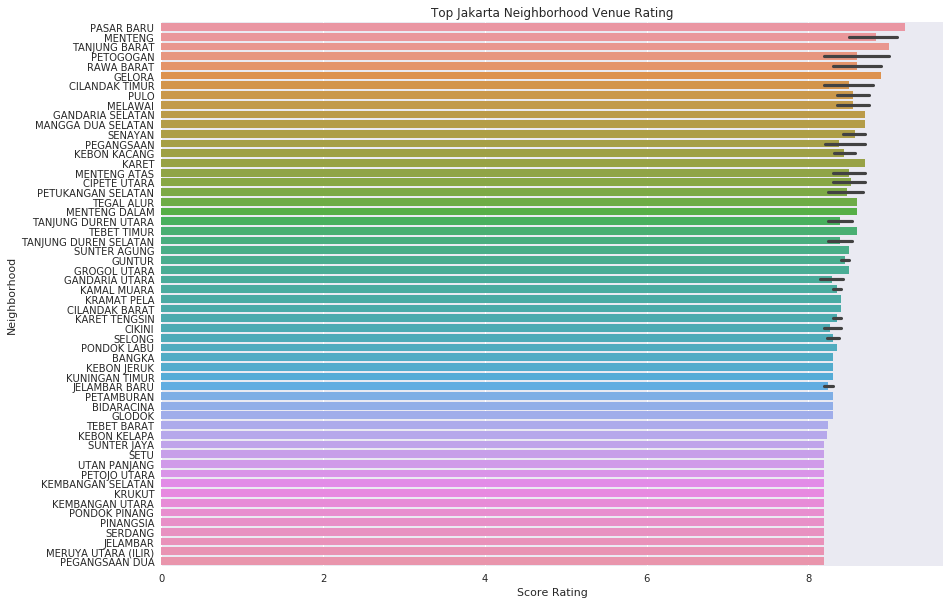

In [92]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(14,10)})
axis = sns.barplot(data = top_100_venue_score.reset_index(), x = 'Venue Score', y = 'Neighborhood')
axis.set_title("Top Jakarta Neighborhood Venue Rating")
axis.set_xlabel('Score Rating')
plt.show()

In [93]:
# Print Jakarta Venue Dataframe Group By Top Score 
Jakarta_top_venue_score=jakarta_venue_filter2.groupby(['Neighborhood','Venue Category'])['Venue Score'].mean().sort_values(ascending=False)

# Save dataframe for future use
Jakarta_top_venue_score.to_csv('Jakarta_top_venue_score.csv')

# Save Jakarta dataframe for future use
file = "Jakarta_top_venue_score.csv"
link = "Storage:Jakarta_top_venue_scorecsv"
file_to_save(Jakarta_top_venue_score,file,link)

In [94]:
# Jakarta Venue Group By Neighborhood
jakarta_venue_filter2.groupby('Neighborhood').count()

,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Unnamed: 0.1,Venue,Venue CatID,Venue Category,Venue Latitude,Venue Longitude,Venue Score,VenueID
Neighborhood,,,,,,,,,,,
ANGKE,1,1,1,1,1,1,1,1,1,1,1
BALEKAMBANG,1,1,1,1,1,1,1,1,1,1,1
BALI MESTER,13,13,13,13,13,13,13,13,13,13,13
BAMBU APUS,3,3,3,3,3,3,3,3,3,3,3
BANGKA,80,80,80,80,80,80,80,80,80,80,80
BARU,1,1,1,1,1,1,1,1,1,1,1
BATUAMPAR,10,10,10,10,10,10,10,10,10,10,10
BENDUNGAN HILIR,13,13,13,13,13,13,13,13,13,13,13
BIDARACINA,6,6,6,6,6,6,6,6,6,6,6


In [95]:
# Print Unique Categories on Neighborhood
print('There are {} uniques categories.'.format(len(jakarta_venue_filter2['Venue Category'].unique())))

There are 42 uniques categories.


In [96]:
# Use one hot encoding
jakarta_onehot = pd.get_dummies(jakarta_venue_filter2[['Venue Category']], prefix="", prefix_sep="")
jakarta_onehot.head()

,Acehnese Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bed & Breakfast,Beer Garden,Betawinese Restaurant,Bistro,Café,...,Pizza Place,Restaurant,Salad Place,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Vietnamese Restaurant,Wine Bar
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
# Put neighborhood back on to dataframe
jakarta_onehot['Neighborhood'] = jakarta_venue_filter2['Neighborhood'] 

# Rearange neighborhood columns
fixed_columns = [jakarta_onehot.columns[-1]] + list(jakarta_onehot.columns[:-1])
jakarta_onehot = jakarta_onehot[fixed_columns]

jakarta_onehot.head()

,Neighborhood,Acehnese Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bed & Breakfast,Beer Garden,Betawinese Restaurant,Bistro,...,Pizza Place,Restaurant,Salad Place,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Vietnamese Restaurant,Wine Bar
5,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,GAMBIR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
jakarta_grouped = jakarta_onehot.groupby('Neighborhood').mean().reset_index()
print(jakarta_grouped.shape)
jakarta_grouped.head()

(231, 43)


,Neighborhood,Acehnese Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bed & Breakfast,Beer Garden,Betawinese Restaurant,Bistro,...,Pizza Place,Restaurant,Salad Place,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Vietnamese Restaurant,Wine Bar
0,ANGKE,0.0,0.0,0.000000,0.000,1.000000,0.0,0.00,0.0,0.000,...,0.00,0.000,0.0,0.000000,0.0,0.0,0.000,0.000,0.0,0.0
1,BALEKAMBANG,0.0,0.0,0.000000,0.000,0.000000,0.0,0.00,0.0,0.000,...,0.00,1.000,0.0,0.000000,0.0,0.0,0.000,0.000,0.0,0.0
2,BALI MESTER,0.0,0.0,0.153846,0.000,0.076923,0.0,0.00,0.0,0.000,...,0.00,0.000,0.0,0.076923,0.0,0.0,0.000,0.000,0.0,0.0
3,BAMBU APUS,0.0,0.0,0.000000,0.000,0.000000,0.0,0.00,0.0,0.000,...,0.00,0.000,0.0,0.333333,0.0,0.0,0.000,0.000,0.0,0.0
4,BANGKA,0.0,0.0,0.050000,0.025,0.025000,0.0,0.05,0.0,0.025,...,0.05,0.175,0.0,0.000000,0.0,0.0,0.025,0.025,0.0,0.0


### Print each neighborhood along with the top 10 most common venues


In [99]:
num_top_venues = 10
for neigh in jakarta_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = jakarta_grouped[jakarta_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ANGKE----
                       venue  freq
0                     Bakery   1.0
1        Acehnese Restaurant   0.0
2                Pizza Place   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.0
7          Korean Restaurant   0.0
8           Malay Restaurant   0.0
9  Middle Eastern Restaurant   0.0


----BALEKAMBANG----
                       venue  freq
0                 Restaurant   1.0
1        Acehnese Restaurant   0.0
2               Noodle House   0.0
3          Indian Restaurant   0.0
4  Indonesian Meatball Place   0.0
5      Indonesian Restaurant   0.0
6         Italian Restaurant   0.0
7        Japanese Restaurant   0.0
8          Korean Restaurant   0.0
9           Malay Restaurant   0.0


----BALI MESTER----
                   venue  freq
0       Asian Restaurant  0.15
1   Fast Food Restaurant  0.15
2    Japanese Restaurant  0.08
3                 Bakery  0.08
4    Fried Chicke

                       venue  freq
0      Indonesian Restaurant  0.17
1                       Café  0.13
2                Coffee Shop  0.09
3               Noodle House  0.09
4        Japanese Restaurant  0.09
5                     Bakery  0.09
6      Betawinese Restaurant  0.09
7  Middle Eastern Restaurant  0.04
8         Seafood Restaurant  0.04
9               Dessert Shop  0.04


----CILANDAK BARAT----
                       venue  freq
0                Coffee Shop   0.5
1                 Soup Place   0.5
2        Acehnese Restaurant   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.0
7          Korean Restaurant   0.0
8           Malay Restaurant   0.0
9  Middle Eastern Restaurant   0.0


----CILANDAK TIMUR----
                   venue  freq
0  Indonesian Restaurant  0.14
1       Asian Restaurant  0.14
2             Food Truck  0.14
3             Restaurant  0.07
4    American Restaurant 

                   venue  freq
0            Coffee Shop  0.21
1  Indonesian Restaurant  0.21
2             Soup Place  0.14
3             Restaurant  0.14
4           Dessert Shop  0.07
5                 Bakery  0.07
6             Food Truck  0.07
7    Japanese Restaurant  0.07
8     Italian Restaurant  0.00
9      Korean Restaurant  0.00


----GEDONG----
                       venue  freq
0                 Food Court   0.5
1       Fast Food Restaurant   0.5
2        Acehnese Restaurant   0.0
3                 Hookah Bar   0.0
4  Indonesian Meatball Place   0.0
5      Indonesian Restaurant   0.0
6         Italian Restaurant   0.0
7        Japanese Restaurant   0.0
8          Korean Restaurant   0.0
9           Malay Restaurant   0.0


----GELORA----
                   venue  freq
0                   Café  0.17
1    Japanese Restaurant  0.13
2             Restaurant  0.13
3            Coffee Shop  0.13
4  Indonesian Restaurant  0.09
5                 Bakery  0.09
6     Chinese Restauran

                       venue  freq
0                     Bakery   1.0
1        Acehnese Restaurant   0.0
2                Pizza Place   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.0
7          Korean Restaurant   0.0
8           Malay Restaurant   0.0
9  Middle Eastern Restaurant   0.0


----KALI BARU----
                       venue  freq
0                     Bakery   1.0
1        Acehnese Restaurant   0.0
2                Pizza Place   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.0
7          Korean Restaurant   0.0
8           Malay Restaurant   0.0
9  Middle Eastern Restaurant   0.0


----KALIBATA----
                   venue  freq
0           Noodle House   0.4
1            Coffee Shop   0.2
2                 Bakery   0.2
3                   Café   0.2
4             Restaurant   0.0
5  In

                       venue  freq
0                 Food Court   1.0
1        Acehnese Restaurant   0.0
2               Noodle House   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.0
7          Korean Restaurant   0.0
8           Malay Restaurant   0.0
9  Middle Eastern Restaurant   0.0


----KEBON JERUK----
                   venue  freq
0            Coffee Shop  0.14
1  Indonesian Restaurant  0.14
2                 Bakery  0.14
3             Steakhouse  0.14
4   Fast Food Restaurant  0.14
5     Seafood Restaurant  0.14
6            Pizza Place  0.14
7           Noodle House  0.00
8     Italian Restaurant  0.00
9    Japanese Restaurant  0.00


----KEBON KACANG----
                 venue  freq
0          Coffee Shop  0.18
1   Chinese Restaurant  0.11
2  Japanese Restaurant  0.11
3           Restaurant  0.08
4     Asian Restaurant  0.05
5          Pizza Place  0.05
6     Sushi Restaurant  0.

                       venue  freq
0                 Food Truck   0.5
1      Indonesian Restaurant   0.5
2        Acehnese Restaurant   0.0
3               Noodle House   0.0
4  Indonesian Meatball Place   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.0
7          Korean Restaurant   0.0
8           Malay Restaurant   0.0
9  Middle Eastern Restaurant   0.0


----KOTA BAMBU SELATAN----
                       venue  freq
0                Pizza Place  0.29
1               Noodle House  0.14
2                 Food Truck  0.14
3                 Donut Shop  0.14
4  Indonesian Meatball Place  0.14
5           Asian Restaurant  0.14
6                 Steakhouse  0.00
7           Malay Restaurant  0.00
8      Indonesian Restaurant  0.00
9         Italian Restaurant  0.00


----KOTA BAMBU UTARA----
                       venue  freq
0                Pizza Place  0.29
1               Noodle House  0.14
2                 Food Truck  0.14
3                 Donut Shop  0.14

                   venue  freq
0            Coffee Shop  0.33
1                   Café  0.08
2     Italian Restaurant  0.08
3   Fast Food Restaurant  0.08
4             Restaurant  0.08
5     Chinese Restaurant  0.08
6  Indonesian Restaurant  0.08
7             Steakhouse  0.08
8                 Bakery  0.08
9            Snack Place  0.00


----MENTENG ATAS----
                   venue  freq
0            Coffee Shop  0.19
1             Food Court  0.12
2             Restaurant  0.12
3     Italian Restaurant  0.06
4   Fast Food Restaurant  0.06
5       Asian Restaurant  0.06
6  Vietnamese Restaurant  0.06
7                 Bakery  0.06
8                   Café  0.06
9             Food Truck  0.06


----MENTENG DALAM----
                       venue  freq
0           Asian Restaurant  0.18
1                 Restaurant  0.18
2  Indonesian Meatball Place  0.09
3               Noodle House  0.09
4                  BBQ Joint  0.09
5                     Bakery  0.09
6      Indonesian Restaura

                 venue  freq
0   Chinese Restaurant  0.18
1          Coffee Shop  0.11
2           Donut Shop  0.09
3         Noodle House  0.09
4     Sushi Restaurant  0.07
5  Japanese Restaurant  0.07
6     Asian Restaurant  0.04
7               Bakery  0.04
8           Restaurant  0.04
9          Snack Place  0.04


----PESANGGRAHAN----
                       venue  freq
0                     Bakery   1.0
1        Acehnese Restaurant   0.0
2                Pizza Place   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.0
7          Korean Restaurant   0.0
8           Malay Restaurant   0.0
9  Middle Eastern Restaurant   0.0


----PETAMBURAN----
                       venue  freq
0      Indonesian Restaurant  0.29
1                Coffee Shop  0.14
2  Middle Eastern Restaurant  0.14
3                 Food Truck  0.14
4  Indonesian Meatball Place  0.14
5           Asian Restaurant  0.14
6      

                       venue  freq
0                Coffee Shop   1.0
1        Acehnese Restaurant   0.0
2  Indonesian Meatball Place   0.0
3      Indonesian Restaurant   0.0
4         Italian Restaurant   0.0
5        Japanese Restaurant   0.0
6          Korean Restaurant   0.0
7           Malay Restaurant   0.0
8  Middle Eastern Restaurant   0.0
9               Noodle House   0.0


----RAGUNAN----
                 venue  freq
0     Asian Restaurant  0.17
1           Food Truck  0.17
2         Noodle House  0.17
3           Donut Shop  0.08
4               Bakery  0.08
5           Steakhouse  0.08
6                 Café  0.08
7   Chinese Restaurant  0.08
8  Dumpling Restaurant  0.08
9  Acehnese Restaurant  0.00


----RAMBUTAN----
                       venue  freq
0                     Bakery   1.0
1        Acehnese Restaurant   0.0
2                Pizza Place   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japan

                   venue  freq
0       Asian Restaurant  0.18
1     Chinese Restaurant  0.18
2           Noodle House  0.14
3                   Café  0.11
4                 Bakery  0.07
5  Indonesian Restaurant  0.07
6     Seafood Restaurant  0.04
7             Donut Shop  0.04
8           Dessert Shop  0.04
9             Restaurant  0.04


----SUNTER JAYA----
                   venue  freq
0       Asian Restaurant   0.2
1  Indonesian Restaurant   0.2
2        Bed & Breakfast   0.2
3             Food Court   0.2
4   Fast Food Restaurant   0.2
5    Acehnese Restaurant   0.0
6           Noodle House   0.0
7     Italian Restaurant   0.0
8    Japanese Restaurant   0.0
9      Korean Restaurant   0.0


----SUSUKAN----
                       venue  freq
0                     Bakery   1.0
1        Acehnese Restaurant   0.0
2                Pizza Place   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.

                       venue  freq
0                     Bakery   1.0
1        Acehnese Restaurant   0.0
2                Pizza Place   0.0
3  Indonesian Meatball Place   0.0
4      Indonesian Restaurant   0.0
5         Italian Restaurant   0.0
6        Japanese Restaurant   0.0
7          Korean Restaurant   0.0
8           Malay Restaurant   0.0
9  Middle Eastern Restaurant   0.0


----WIJAYA KUSUMA----
                  venue  freq
0          Noodle House   0.2
1    Dim Sum Restaurant   0.1
2   Japanese Restaurant   0.1
3            Steakhouse   0.1
4   Fried Chicken Joint   0.1
5            Food Truck   0.1
6  Fast Food Restaurant   0.1
7    Chinese Restaurant   0.1
8           Coffee Shop   0.1
9   Acehnese Restaurant   0.0




### Create the new dataframe and display the top 10 venues for each neighborhood.


In [100]:
def popular_venue(row, num_top_venues):
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending=False)
    
    return row_cat_sorted.index.values[0:num_top_venues]

In [101]:
num_top_venues = 10
# First, Second and Third
indicators = ['st', 'nd', 'rd'] 

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neigh_venues_sorted = pd.DataFrame(columns=columns)
neigh_venues_sorted['Neighborhood'] = jakarta_grouped['Neighborhood']

for ind in np.arange(jakarta_grouped.shape[0]):
    neigh_venues_sorted.iloc[ind, 1:] = popular_venue(jakarta_grouped.iloc[ind, :], num_top_venues)

In [102]:
neigh_venues_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 11 columns):
Neighborhood              231 non-null object
1st Most Common Venue     231 non-null object
2nd Most Common Venue     231 non-null object
3rd Most Common Venue     231 non-null object
4th Most Common Venue     231 non-null object
5th Most Common Venue     231 non-null object
6th Most Common Venue     231 non-null object
7th Most Common Venue     231 non-null object
8th Most Common Venue     231 non-null object
9th Most Common Venue     231 non-null object
10th Most Common Venue    231 non-null object
dtypes: object(11)
memory usage: 19.9+ KB


In [103]:
print(neigh_venues_sorted.shape)
neigh_venues_sorted.head()

(231, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANGKE,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop
1,BALEKAMBANG,Restaurant,Wine Bar,Café,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop
2,BALI MESTER,Fast Food Restaurant,Asian Restaurant,Fried Chicken Joint,Food Court,Indonesian Restaurant,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Food Truck,Seafood Restaurant
3,BAMBU APUS,Indonesian Restaurant,Seafood Restaurant,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop
4,BANGKA,Restaurant,Coffee Shop,Fried Chicken Joint,Dim Sum Restaurant,Chinese Restaurant,Café,Japanese Restaurant,Pizza Place,Beer Garden,Asian Restaurant


In [104]:
neigh_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANGKE,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop
1,BALEKAMBANG,Restaurant,Wine Bar,Café,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop
2,BALI MESTER,Fast Food Restaurant,Asian Restaurant,Fried Chicken Joint,Food Court,Indonesian Restaurant,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Food Truck,Seafood Restaurant
3,BAMBU APUS,Indonesian Restaurant,Seafood Restaurant,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop
4,BANGKA,Restaurant,Coffee Shop,Fried Chicken Joint,Dim Sum Restaurant,Chinese Restaurant,Café,Japanese Restaurant,Pizza Place,Beer Garden,Asian Restaurant
5,BARU,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop
6,BATUAMPAR,Fast Food Restaurant,Pizza Place,Donut Shop,Cupcake Shop,Indonesian Restaurant,Japanese Restaurant,Fried Chicken Joint,Seafood Restaurant,Bakery,Bed & Breakfast
7,BENDUNGAN HILIR,Indonesian Restaurant,Pizza Place,Acehnese Restaurant,Food Truck,Soup Place,Snack Place,Restaurant,Coffee Shop,Bistro,Chinese Restaurant
8,BIDARACINA,Fast Food Restaurant,American Restaurant,Indonesian Restaurant,Pizza Place,Noodle House,Café,Chinese Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant
9,BINTARO,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop


### Cluster Neighborhoods

Run k-means to cluster the neighborhood into clusters.

In [105]:
# Import Sklearn cluster
from sklearn.cluster import KMeans

# Import plot libraries
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#### Find out optimal K with knee method

In [106]:
# Prepare dataframe for Machine Learning. 
# Remove Neighborhood Column
jakarta_grouped_clustering = jakarta_grouped.drop('Neighborhood', 1)

In [107]:
# Use Sum Square Distance Sum of Square Error
sse = []
idx = range(1, 15)
for k in idx:
    knn = KMeans(n_clusters=k)
    knn = knn.fit(jakarta_grouped_clustering)
    sse.append(knn.inertia_)

In [108]:
optimal_k= pd.DataFrame(data= sse, columns = ['Sum Square Error'], index = idx)
optimal_k.rename_axis('K Value', axis = 'columns', inplace = True)
#optimal_k

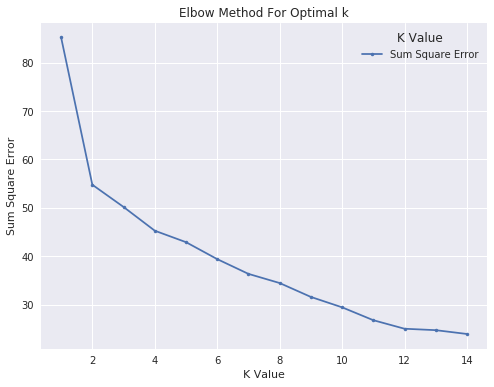

In [109]:
optimal_k.plot(kind = 'line', figsize = (8, 6), marker = '.')
plt.xlabel('K Value')
plt.ylabel('Sum Square Error')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems that our best suitable K value is 4.

In [110]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jakarta_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 0, 3, 3, 1, 0, 3, 0, 1], dtype=int32)

### Now let's put our cluster labels in our neighborhoods_venues_sorted data frame

In [111]:
jakarta_merge1 = neigh_venues_sorted

In [112]:
jakarta_merge1.shape

(231, 11)

In [113]:
# add clustering labels
jakarta_merge1['Cluster Labels'] = kmeans.labels_

In [114]:
print(jakarta_merge1.shape)
jakarta_merge1.head()

(231, 12)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,ANGKE,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
1,BALEKAMBANG,Restaurant,Wine Bar,Café,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,3
2,BALI MESTER,Fast Food Restaurant,Asian Restaurant,Fried Chicken Joint,Food Court,Indonesian Restaurant,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Food Truck,Seafood Restaurant,0
3,BAMBU APUS,Indonesian Restaurant,Seafood Restaurant,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,3
4,BANGKA,Restaurant,Coffee Shop,Fried Chicken Joint,Dim Sum Restaurant,Chinese Restaurant,Café,Japanese Restaurant,Pizza Place,Beer Garden,Asian Restaurant,3


In [115]:
jakarta_fill_df=jakarta_df5.filter(['PostalCode','Latitude','Longitude','Subdistricts','Regency'], axis=1)

In [116]:
jakarta_merge2 = jakarta_fill_df.join(jakarta_merge1.set_index('Neighborhood'), on='Subdistricts')

In [117]:
jakarta_merge3= jakarta_merge2 

In [118]:
print(jakarta_merge3.shape)
jakarta_merge3.head()

(266, 16)


,PostalCode,Latitude,Longitude,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,-6.175811,106.826906,GAMBIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Food Truck,Soup Place,Cupcake Shop,Coffee Shop,Noodle House,Japanese Restaurant,Chinese Restaurant,Dumpling Restaurant,3.0
1,10120,-6.162065,106.826741,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Indonesian Meatball Place,Beer Garden,Steakhouse,Snack Place,BBQ Joint,Dessert Shop,0.0
2,10130,-6.164882,106.818566,PETOJO UTARA,JAKARTA PUSAT,Noodle House,Donut Shop,Fast Food Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,0.0
3,10140,-6.165196,106.810215,DURI PULO,JAKARTA PUSAT,Soup Place,Indonesian Restaurant,Café,Food Truck,Pizza Place,Noodle House,Chinese Restaurant,Donut Shop,Indian Restaurant,Restaurant,3.0
4,10150,-6.167405,106.812690,CIDENG,JAKARTA PUSAT,Noodle House,Indonesian Restaurant,Food Truck,Soup Place,Pizza Place,Donut Shop,Café,Seafood Restaurant,Bakery,Restaurant,3.0


In [119]:
jakarta_merge4=jakarta_merge3.dropna(how='any')

In [120]:
print(jakarta_merge4.shape)
jakarta_merge4.head()

(231, 16)


,PostalCode,Latitude,Longitude,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,-6.175811,106.826906,GAMBIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Food Truck,Soup Place,Cupcake Shop,Coffee Shop,Noodle House,Japanese Restaurant,Chinese Restaurant,Dumpling Restaurant,3.0
1,10120,-6.162065,106.826741,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Indonesian Meatball Place,Beer Garden,Steakhouse,Snack Place,BBQ Joint,Dessert Shop,0.0
2,10130,-6.164882,106.818566,PETOJO UTARA,JAKARTA PUSAT,Noodle House,Donut Shop,Fast Food Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,0.0
3,10140,-6.165196,106.810215,DURI PULO,JAKARTA PUSAT,Soup Place,Indonesian Restaurant,Café,Food Truck,Pizza Place,Noodle House,Chinese Restaurant,Donut Shop,Indian Restaurant,Restaurant,3.0
4,10150,-6.167405,106.812690,CIDENG,JAKARTA PUSAT,Noodle House,Indonesian Restaurant,Food Truck,Soup Place,Pizza Place,Donut Shop,Café,Seafood Restaurant,Bakery,Restaurant,3.0


In [121]:
jakarta_merge4['Cluster Labels'] = jakarta_merge4['Cluster Labels'].astype(int)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [122]:
print(jakarta_merge4.shape)
jakarta_merge4.head()

(231, 16)


,PostalCode,Latitude,Longitude,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,-6.175811,106.826906,GAMBIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Food Truck,Soup Place,Cupcake Shop,Coffee Shop,Noodle House,Japanese Restaurant,Chinese Restaurant,Dumpling Restaurant,3
1,10120,-6.162065,106.826741,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Indonesian Meatball Place,Beer Garden,Steakhouse,Snack Place,BBQ Joint,Dessert Shop,0
2,10130,-6.164882,106.818566,PETOJO UTARA,JAKARTA PUSAT,Noodle House,Donut Shop,Fast Food Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,0
3,10140,-6.165196,106.810215,DURI PULO,JAKARTA PUSAT,Soup Place,Indonesian Restaurant,Café,Food Truck,Pizza Place,Noodle House,Chinese Restaurant,Donut Shop,Indian Restaurant,Restaurant,3
4,10150,-6.167405,106.812690,CIDENG,JAKARTA PUSAT,Noodle House,Indonesian Restaurant,Food Truck,Soup Place,Pizza Place,Donut Shop,Café,Seafood Restaurant,Bakery,Restaurant,3


### Visualized Neighborhood

In [123]:
# create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jakarta_merge4['Latitude'],jakarta_merge4['Longitude'], jakarta_merge4['Subdistricts'],jakarta_merge4['Cluster Labels']):
    #print(rainbow[cluster-1])
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine each of the clusters

#### Cluster 1

In [124]:
jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 0, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,10120,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Indonesian Meatball Place,Beer Garden,Steakhouse,Snack Place,BBQ Joint,Dessert Shop,0
2,10130,PETOJO UTARA,JAKARTA PUSAT,Noodle House,Donut Shop,Fast Food Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,0
21,10440,PASEBAN,JAKARTA PUSAT,Fast Food Restaurant,Indonesian Restaurant,Asian Restaurant,Restaurant,Coffee Shop,Café,Food Court,Noodle House,Fried Chicken Joint,Steakhouse,0
24,10510,CEMPAKA PUTIH TIMUR,JAKARTA PUSAT,Fast Food Restaurant,Asian Restaurant,Restaurant,Indonesian Restaurant,Coffee Shop,Café,Food Court,Noodle House,Fried Chicken Joint,Betawinese Restaurant,0
29,10560,JOHAR BARU,JAKARTA PUSAT,Fast Food Restaurant,Wine Bar,Chinese Restaurant,Food Court,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,0
32,10620,KEMAYORAN,JAKARTA PUSAT,Food Court,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,0
37,10650,SERDANG,JAKARTA PUSAT,Pizza Place,Fast Food Restaurant,Noodle House,Wine Bar,Café,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,0
38,10650,UTAN PANJANG,JAKARTA PUSAT,Pizza Place,Fast Food Restaurant,Noodle House,Wine Bar,Café,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,0
41,10730,MANGGA DUA SELATAN,JAKARTA PUSAT,Chinese Restaurant,Dessert Shop,Noodle House,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Donut Shop,Food Truck,Café,Coffee Shop,0
45,11120,GLODOK,JAKARTA BARAT,Noodle House,Chinese Restaurant,Indonesian Restaurant,Food Court,Coffee Shop,Asian Restaurant,Dumpling Restaurant,Dessert Shop,Food Truck,Fast Food Restaurant,0


In [125]:
cluster1=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 0, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]# Save Jakarta dataframe for future use

file = "Jakarta_cluster1.csv"
link = "Storage:Jakarta_cluster1_csv"
file_to_save(cluster1,file,link)

In [126]:
cluster1

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,10120,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Indonesian Meatball Place,Beer Garden,Steakhouse,Snack Place,BBQ Joint,Dessert Shop,0
2,10130,PETOJO UTARA,JAKARTA PUSAT,Noodle House,Donut Shop,Fast Food Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Bed & Breakfast,0
21,10440,PASEBAN,JAKARTA PUSAT,Fast Food Restaurant,Indonesian Restaurant,Asian Restaurant,Restaurant,Coffee Shop,Café,Food Court,Noodle House,Fried Chicken Joint,Steakhouse,0
24,10510,CEMPAKA PUTIH TIMUR,JAKARTA PUSAT,Fast Food Restaurant,Asian Restaurant,Restaurant,Indonesian Restaurant,Coffee Shop,Café,Food Court,Noodle House,Fried Chicken Joint,Betawinese Restaurant,0
29,10560,JOHAR BARU,JAKARTA PUSAT,Fast Food Restaurant,Wine Bar,Chinese Restaurant,Food Court,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,0
32,10620,KEMAYORAN,JAKARTA PUSAT,Food Court,Wine Bar,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Coffee Shop,0
37,10650,SERDANG,JAKARTA PUSAT,Pizza Place,Fast Food Restaurant,Noodle House,Wine Bar,Café,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,0
38,10650,UTAN PANJANG,JAKARTA PUSAT,Pizza Place,Fast Food Restaurant,Noodle House,Wine Bar,Café,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,0
41,10730,MANGGA DUA SELATAN,JAKARTA PUSAT,Chinese Restaurant,Dessert Shop,Noodle House,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Donut Shop,Food Truck,Café,Coffee Shop,0
45,11120,GLODOK,JAKARTA BARAT,Noodle House,Chinese Restaurant,Indonesian Restaurant,Food Court,Coffee Shop,Asian Restaurant,Dumpling Restaurant,Dessert Shop,Food Truck,Fast Food Restaurant,0


#### Cluster 2

In [127]:
cluster2=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 1, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]# Save Jakarta dataframe for future use

file = "Jakarta_cluster2.csv"
link = "Storage:Jakarta_cluster2_csv"
file_to_save(cluster2,file,link)

In [128]:
cluster2

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
17,10350,GONDANGDIA,JAKARTA PUSAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
23,10460,BUNGUR,JAKARTA PUSAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
28,10550,KAMPUNG RAWA,JAKARTA PUSAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
52,11210,TANAH SEREAL,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
53,11220,TAMBORA,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
54,11230,ROA MALAKA,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
58,11270,DURI SELATAN,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
59,11270,DURI UTARA,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
60,11310,KALI ANYAR,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1
62,11330,ANGKE,JAKARTA BARAT,Bakery,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,1


#### Cluster 3

In [129]:
cluster3=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 2, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]# Save Jakarta dataframe for future use

file = "Jakarta_cluster3.csv"
link = "Storage:Jakarta_cluster3_csv"
file_to_save(cluster3,file,link)

In [130]:
cluster3

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
34,10640,CEMPAKA BARU,JAKARTA PUSAT,Coffee Shop,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,2
35,10640,HARAPAN MULYA,JAKARTA PUSAT,Coffee Shop,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,2
36,10640,SUMUR BATU,JAKARTA PUSAT,Coffee Shop,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,2
76,11510,DURI KEPA,JAKARTA BARAT,Food Truck,Coffee Shop,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,2
95,11810,KAMAL,JAKARTA BARAT,Coffee Shop,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,2
123,12430,CILANDAK BARAT,JAKARTA SELATAN,Soup Place,Coffee Shop,Wine Bar,Café,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,2
144,12760,DUREN TIGA,JAKARTA SELATAN,Sushi Restaurant,Coffee Shop,Wine Bar,Café,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,2
161,12950,KUNINGAN TIMUR,JAKARTA SELATAN,Coffee Shop,Wine Bar,Restaurant,Food Truck,Vietnamese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Food Court,Betawinese Restaurant,2
177,13260,PULO GADUNG,JAKARTA TIMUR,Coffee Shop,Wine Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,2
183,13410,CIPINANG BESAR SELATAN,JAKARTA TIMUR,Coffee Shop,Café,Food Court,Asian Restaurant,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,2


#### Cluster 4

In [131]:
cluster4=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 3, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]# Save Jakarta dataframe for future use

file = "Jakarta_cluster4.csv"
link = "Storage:Jakarta_cluster4_csv"
file_to_save(cluster4,file,link)

In [132]:
cluster4

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,GAMBIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Food Truck,Soup Place,Cupcake Shop,Coffee Shop,Noodle House,Japanese Restaurant,Chinese Restaurant,Dumpling Restaurant,3
3,10140,DURI PULO,JAKARTA PUSAT,Soup Place,Indonesian Restaurant,Café,Food Truck,Pizza Place,Noodle House,Chinese Restaurant,Donut Shop,Indian Restaurant,Restaurant,3
4,10150,CIDENG,JAKARTA PUSAT,Noodle House,Indonesian Restaurant,Food Truck,Soup Place,Pizza Place,Donut Shop,Café,Seafood Restaurant,Bakery,Restaurant,3
5,10160,PETOJO SELATAN,JAKARTA PUSAT,Indonesian Restaurant,Food Truck,Coffee Shop,BBQ Joint,Restaurant,Noodle House,Food Court,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,3
6,10210,BENDUNGAN HILIR,JAKARTA PUSAT,Indonesian Restaurant,Pizza Place,Acehnese Restaurant,Food Truck,Soup Place,Snack Place,Restaurant,Coffee Shop,Bistro,Chinese Restaurant,3
7,10220,KARET TENGSIN,JAKARTA PUSAT,Japanese Restaurant,Coffee Shop,Indonesian Restaurant,Asian Restaurant,Restaurant,Wine Bar,Sushi Restaurant,Café,Pizza Place,BBQ Joint,3
8,10230,KEBON MELATI,JAKARTA PUSAT,Soup Place,Indonesian Meatball Place,Indonesian Restaurant,Wine Bar,Chinese Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,3
9,10240,KEBON KACANG,JAKARTA PUSAT,Coffee Shop,Japanese Restaurant,Chinese Restaurant,Restaurant,Sushi Restaurant,Steakhouse,Café,Pizza Place,Asian Restaurant,Korean Restaurant,3
10,10250,KAMPUNG BALI,JAKARTA PUSAT,Indonesian Restaurant,Café,Bed & Breakfast,Fast Food Restaurant,Food Truck,Betawinese Restaurant,Food Court,Asian Restaurant,Beer Garden,Bakery,3
11,10260,PETAMBURAN,JAKARTA PUSAT,Indonesian Restaurant,Middle Eastern Restaurant,Coffee Shop,Indonesian Meatball Place,Food Truck,Asian Restaurant,Bakery,Bed & Breakfast,Fast Food Restaurant,Dumpling Restaurant,3


## Conclusion

Recommendation based on top 100 food venue in Jakarta has been presented above. Jakarta multi-cultural background population would be perfect for food lover who want to experience many kind of food. 

Jakarta neighborhood segmented to 4 cluster based on recommendation of machine learning algorithm. On cluster 1, Indonesian restaurant dominate top venue, bakery for cluster2, coffee shop for cluster 3, and chinese-japanese-noodle house-restaurant on cluster4. 

Top rating venue like Menteng Steakhouse and Gelora American Restaurant included in Cluster 4. These venue, received score 8.9 and up. 

I have collected around 35% top ranking food venue in Jakarta due to limitation of free version of Foursquare API. The result might significantly different from presented above when using full version.